In [2]:
import pandas as pd
import datetime as DT
import re

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier

import math
from __future__ import division

from itertools import islice

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import nltk
import re
from collections import Counter
import string
import pprint

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/travisallen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. AlzU Survey Data Section

In [3]:
ALZU_RESPONSES_FILE_PATH = '../Data_Folder/2018.09.18_AlzU_ANU-DRI + Responses_Numerical.csv'

## Combine first two rows to generate column names

In [4]:
two_header_rows = pd.read_csv(ALZU_RESPONSES_FILE_PATH, header=None, nrows = 2, delimiter = ",", keep_default_na=False)

transformed_header_row = []

most_recent_col_first_row = None
for column in two_header_rows:
    primary_header = two_header_rows[column][0]
    sub_header = two_header_rows[column][1]
#     print(primary_header + ": " + sub_header)
    if(primary_header != ""):
        most_recent_col_first_row = primary_header
    transformed_header_row.append(most_recent_col_first_row + "_" + sub_header)

## Load Data with column names


        

In [5]:
alzu_survey_data = pd.read_csv(ALZU_RESPONSES_FILE_PATH, header=None, skiprows = [0,1], delimiter = ",", keep_default_na=False, names=transformed_header_row)

alzu_survey_data.head()

Respondent ID_  Collector ID_          Start Date_            End Date_     IP Address_ Email Address_ First Name_ Last Name_ Custom Data 1_ How many lessons did you complete on AlzU.org?_Response Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Other (please specify) Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss ways to lower AD risk?  \
0      6936062570      170620047   2018-09-05 9:46:59   2018-09-05 9:50:09  72.239.164.168                                                                                                       3                                                                                                                                                                                                                                                                                                                                   3                                                                                                                                                                                                               
1      6935898635      170620047  2018-09-04 20:43:46  2018-09-04 22:55:52   73.230.13.240                                                                                                       2                                                       1                                                                                                                                                                                                                                                                           2                                                                                                                                                                                                               
2      6935793919      170620047  2018-09-04 16:23:38  2018-09-04 16:26:34   98.155.32.231                                                                                                       2                                                       3                                                                                                                                                                                                                                                                           5                                                                                                                                                                                                               
3      6935733915      170620047  2018-09-04 14:10:18  2018-09-04 14:27:56     12.33.32.71                                                                                                       2                                                       0                                                                              I am not able to complete at home or at work f...                                                                                                                                            5                                                                                                                                                                                                               
4      6935603649      170620047   2018-09-04 9:27:18  2018-09-04 10:48:34   160.2.106.111                                                                                                       3                                                                                                                                                                                   

In [6]:
alzu_survey_data.shape

(1458, 129)

In [7]:
for idx, col in enumerate(alzu_survey_data.columns):
    print(str(idx) + " : " + str(col))

0 : Respondent ID_
1 : Collector ID_
2 : Start Date_
3 : End Date_
4 : IP Address_
5 : Email Address_
6 : First Name_
7 : Last Name_
8 : Custom Data 1_
9 : How many lessons did you complete on AlzU.org?_Response
10 : Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response
11 : Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Other (please specify)
12 : Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss ways to lower AD risk?
13 : Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Participated in an AD prevention rese

In [8]:
tech_prompt_idx = 123
tec_prompt_idx = 124

tech_prompt = alzu_survey_data.columns[tech_prompt_idx]
tec_prompt = alzu_survey_data.columns[tec_prompt_idx]

print("Num respondents to memory prompt: "+ str(alzu_survey_data[alzu_survey_data[tech_prompt] != ''].shape[0]))
print("Num respondents to tech prompt: "+ str(alzu_survey_data[alzu_survey_data[tec_prompt] != ''].shape[0]))

Num respondents to memory prompt: 373
Num respondents to tech prompt: 434


Below I am exploring how many users have submitted multiple surveys.  After inspecting many of these users responses, I decide to only keep their most recent survey response, because empirically it seems like that one has the richest data -- the other submissions tend to be minutes before and have no responses, making me think they were having technical difficulties.

There may be a smarter way to do this instead of just keeping the most recent one -- maybe there is a metric to determine which responses is "most-complete".

#### I have confirmed that by dropping duplicates below, we lose 9 memory prompt responses and 10 tech prompt responses...Worth considering what is best to do...

In [9]:
val_counts = alzu_survey_data['uid_Open-Ended Response'].value_counts()

num_users_multiple_submissions = val_counts[val_counts != 1].shape[0]

print("There are " + str(num_users_multiple_submissions) + " users who submitted multiple surveys.")
# print(val_counts)


There are 102 users who submitted multiple surveys.


In [10]:
alzu_survey_data.drop_duplicates('uid_Open-Ended Response', keep='first', inplace=True)

# 2. CFT Data Section

In [11]:
CFT_FILE_PATH = '../Data_Folder/2018.09_CFT_all.csv'

In [12]:
cft_data = pd.read_csv(CFT_FILE_PATH, delimiter = ",", keep_default_na=False)

In [13]:
cft_data.head()

UserID    FirstName                    EmailAddress          DoB Gender              RegDate Country Postcode   Source Ethnicy MouseScore Interrupted Functioned FastInternet ScreenClear   FinalScore            DateTaken Homoscyteine MaritalStatus Dependents Occupation PrimaryIncome HouseholdIncome PrimaryIncomeOccupation FirstPriority SecondPriority OtherPriority  FullTime  PartTime    Working                      CompUser MemConcern ForgetFriends PutThings ForgetWords LoseWay IsMemoryWorse FamilyHistory FamilyHistoryAge                                        Supplements DeviceUsed ass combocs recallscore placescore
0   37894            R         rii9004@med.cornell.edu  1/1/40 0:00      M  28/01/2015 03:19:48                   cornell              17976                                                               28/01/2015 03:24:53         None                                                                                                                                             12         0         No  Intensive data input at Work      False         False     False       False   False         False           yes             mild                                                 No                                              
1   37898            R         rii9004@med.cornell.edu  1/1/60 0:00      M  28/01/2015 03:35:10                   cornell                                                                                  28/01/2015 03:43:24         None                                                                                                                                             12         0  Part Time  Intensive data input at Work      False         False     False       False   False         False            no             none                                                 No                                              
2   37323       Abie 3  abie@catalyst-innovation.co.uk  1/1/30 0:00      M  26/01/2015 17:41:49      UK      RH4  cornell              11734                                                  16.81257227  26/01/2015 17:43:09         None                                                                                                                                              1         3         No                            No      False         False     False       False   False         False            no             alzh         A basic B complex or RDA type multivitamin                                              
3   37318  Abie test 2  abie@catalyst-innovation.co.uk  1/1/77 0:00      M  26/01/2015 17:26:39      UK  KT2 5RN  cornell              12705                                                  10.05161531  26/01/2015 17:31:32         None                                                                                                                                              1         3  Part Time  Intensive data input at Work      False         False     False       False   False         False            no             none  A homocysteine lowering formula (eg Connect, H...                                              
4   37310    Abie test  abie@catalyst-innovation.co.uk  1/1/79 0:00      M  26/01/2015 17:12:48      UK  KT2 5RN  cornell              12047                                                   11.2322015  26/01/2015 17:20:04         None                                                                                                                                              3         2  Full Time  Intensive data input at Work      False         False     False       False   False         False            no             none                                                 No

In [14]:
cft_data.shape

(9309, 45)

Exploration of Dr. Isaacson's Questions about how many times people have taken the CFT for those that have registered between August 22nd and March 7th.

- Do we use "RegDate" in the CFT dataset as the reference date, or do we have to look into the User list for that?
- Do we care about those that registered or do we need a Final Score?

In [15]:
cft_data['RegDate'] = pd.to_datetime(cft_data['RegDate'])

from datetime import datetime
start_string = 'Aug 22 2017'
end_string = 'Mar 05 2018'
start_date = datetime.strptime(start_string, '%b %d %Y')
end_date = datetime.strptime(end_string, '%b %d %Y')
mask = (cft_data['RegDate'] > start_date) & (cft_data['RegDate'] <= end_date)
# Select the sub-DataFrame:

cft_btwn_dates = cft_data.loc[mask]

print (str(cft_btwn_dates.shape[0]) + " users have registered for the CFT between " + start_string + " and " + end_string)

3957 users have registered for the CFT between Aug 22 2017 and Mar 05 2018


In [16]:
cft_btwn_dates.groupby('EmailAddress').count().groupby('UserID').count().ix[:, 2]
# for idx, row in cft_data.groupby('EmailAddress').count().groupby('UserID').count():
#     print idx, row['FirstName']

UserID
1    3377
2     245
3      23
4       3
9       1
Name: Gender, dtype: int64

In [17]:
cft_data.columns

Index([u'UserID', u'FirstName', u'EmailAddress', u'DoB', u'Gender', u'RegDate', u'Country', u'Postcode', u'Source', u'Ethnicy', u'MouseScore', u'Interrupted', u'Functioned', u'FastInternet', u'ScreenClear', u'FinalScore', u'DateTaken', u'Homoscyteine', u'MaritalStatus', u'Dependents', u'Occupation', u'PrimaryIncome', u'HouseholdIncome', u'PrimaryIncomeOccupation', u'FirstPriority', u'SecondPriority', u'OtherPriority', u'FullTime', u'PartTime', u'Working', u'CompUser', u'MemConcern', u'ForgetFriends', u'PutThings', u'ForgetWords', u'LoseWay', u'IsMemoryWorse', u'FamilyHistory', u'FamilyHistoryAge', u'Supplements', u'DeviceUsed', u'ass', u'combocs', u'recallscore', u'placescore'], dtype='object')

## CFT Summary Stats

In [18]:
unique_cft = cft_data.drop_duplicates('EmailAddress', keep='first') # takes the first (oldest) score

print("Number of tests taken: " + str(cft_data.shape[0]))
print("Number of unique users: " + str(unique_cft.shape[0]))

unique_cft.groupby('Gender').count()

Number of tests taken: 9309
Number of unique users: 8242


UserID  FirstName  EmailAddress   DoB  RegDate  Country  Postcode  Source  Ethnicy  MouseScore  Interrupted  Functioned  FastInternet  ScreenClear  FinalScore  DateTaken  Homoscyteine  MaritalStatus  Dependents  Occupation  PrimaryIncome  HouseholdIncome  PrimaryIncomeOccupation  FirstPriority  SecondPriority  OtherPriority  FullTime  PartTime  Working  CompUser  MemConcern  ForgetFriends  PutThings  ForgetWords  LoseWay  IsMemoryWorse  FamilyHistory  FamilyHistoryAge  Supplements  DeviceUsed   ass  combocs  recallscore  placescore
Gender                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
F         7024       7024          7024  7024     7024     7024      7024    7024     7024        7024         7024        7024          7024         7024        7024       7024          7024           7024        7024        7024           7024             7024                     7024           7024            7024           7024      7024      7024     7024      7024        7024           7024       7024         7024     7024           7024           7024              7024         7024        7024  7024     7024         7024        7024
M         1218       1218          1218  1218     1218     1218      1218    1218     1218        1218         1218        1218          1218         1218        1218       1218          1218           1218        1218        1218           1218             1218                     1218           1218            1218           1218      1218      1218     1218      1218        1218           1218       1218         1218     1218           1218           1218              1218         1218        1218  1218     1218         1218        1218

In [19]:
for cft_col in unique_cft.columns:
    print(cft_col)
    

UserID
FirstName
EmailAddress
DoB
Gender
RegDate
Country
Postcode
Source
Ethnicy
MouseScore
Interrupted
Functioned
FastInternet
ScreenClear
FinalScore
DateTaken
Homoscyteine
MaritalStatus
Dependents
Occupation
PrimaryIncome
HouseholdIncome
PrimaryIncomeOccupation
FirstPriority
SecondPriority
OtherPriority
FullTime
PartTime
Working
CompUser
MemConcern
ForgetFriends
PutThings
ForgetWords
LoseWay
IsMemoryWorse
FamilyHistory
FamilyHistoryAge
Supplements
DeviceUsed
ass
combocs
recallscore
placescore


# 3. Email-UserID Section

In [20]:
ALZU_USERS_FILE_PATH = '../Data_Folder/2018.09_alzu_users.csv'

In [21]:
user_data = pd.read_csv(ALZU_USERS_FILE_PATH, delimiter = ",", keep_default_na=False)

In [22]:
user_data.head()

Joined  User ID        First Name                      Email Gender        Lesson Group  Lesson Count  Activ. Start  Activ. Compl.
0  9/11/18    75332              Lori      lori.wolfe@anthem.com      F  Prevention Default             2             3              1
1  9/11/18    75331            Robert           r.mango@live.com      M  Prevention Default             0             0              0
2  9/10/18    75330   George Rothwell            gogogeo@aol.com      M  Prevention Default             0             0              0
3  9/10/18    75329          Celeste   celestelovelace@yahoo.com      F  Prevention Default             0             0              0
4  9/10/18    75328  Laura D Zampaio   jadeverde1971@hotmail.com      F  Prevention Default             0             0              0

## Transformations + Data Cleaning

In [23]:
user_data['Joined'] = pd.to_datetime(user_data['Joined'])
print(user_data.shape)
user_data = user_data.drop_duplicates('Email', keep='last')
print(user_data.shape)



(75005, 9)
(74779, 9)


## User Summary Stats

In [24]:
print("Number of total users: " + str(user_data.shape[0]))
gender_grouping = user_data['Gender'].value_counts()
num_females = gender_grouping['F']
num_males = gender_grouping['M']

print("Number of male users: " + str(num_males))
print("Number of female users: " + str(num_females))
print("Male:Female Ratio ≈ 1:" + str(num_females / num_males))


Number of total users: 74779
Number of male users: 12885
Number of female users: 61894
Male:Female Ratio ≈ 1:4.80357004269


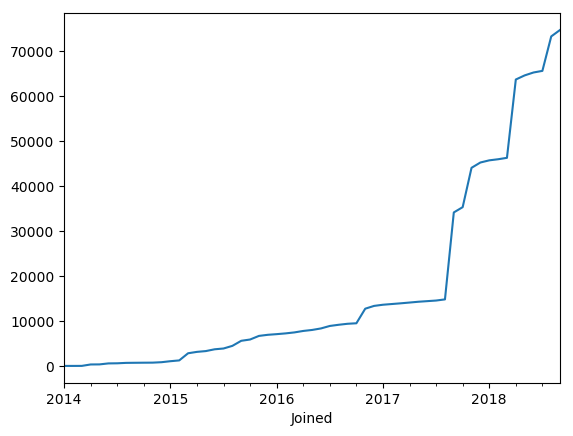

In [25]:
date_indexed = user_data.set_index(user_data["Joined"])
date_indexed['count'] = 1
counts = date_indexed['count'].resample('M').sum().dropna()

counts = counts[2:] #get rid of 2 obviously incorrect ones dating way back

import matplotlib.pyplot as plt
cumulative_counts = counts.cumsum()
cumulative_counts.plot()
plt.show()

# JOIN DATASETS

In [26]:
unique_cft.rename(index=str, columns={"EmailAddress": "Email"}, inplace=True)
alzu_survey_data.rename(index=str, columns={"uid_Open-Ended Response": "User ID"}, inplace=True)

/Users/travisallen/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [27]:
users_joined_cognitive = user_data.merge(unique_cft, on="Email", how="left")

In [28]:
print(users_joined_cognitive.shape)
users_joined_cognitive.head()

(74779, 53)


Joined  User ID        First Name                      Email Gender_x        Lesson Group  Lesson Count  Activ. Start  Activ. Compl.  UserID FirstName  DoB Gender_y RegDate Country Postcode Source Ethnicy MouseScore Interrupted Functioned FastInternet ScreenClear FinalScore DateTaken Homoscyteine MaritalStatus Dependents Occupation PrimaryIncome HouseholdIncome PrimaryIncomeOccupation FirstPriority SecondPriority OtherPriority  FullTime  PartTime Working CompUser MemConcern ForgetFriends PutThings ForgetWords LoseWay IsMemoryWorse FamilyHistory FamilyHistoryAge Supplements DeviceUsed  ass combocs recallscore placescore
0 2018-09-11    75332              Lori      lori.wolfe@anthem.com        F  Prevention Default             2             3              1     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN         NaN        NaN       NaN          NaN           NaN        NaN        NaN           NaN             NaN                     NaN           NaN            NaN           NaN       NaN       NaN     NaN      NaN        NaN           NaN       NaN         NaN     NaN           NaN           NaN              NaN         NaN        NaN  NaN     NaN         NaN        NaN
1 2018-09-11    75331            Robert           r.mango@live.com        M  Prevention Default             0             0              0     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN         NaN        NaN       NaN          NaN           NaN        NaN        NaN           NaN             NaN                     NaN           NaN            NaN           NaN       NaN       NaN     NaN      NaN        NaN           NaN       NaN         NaN     NaN           NaN           NaN              NaN         NaN        NaN  NaN     NaN         NaN        NaN
2 2018-09-10    75330   George Rothwell            gogogeo@aol.com        M  Prevention Default             0             0              0     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN         NaN        NaN       NaN          NaN           NaN        NaN        NaN           NaN             NaN                     NaN           NaN            NaN           NaN       NaN       NaN     NaN      NaN        NaN           NaN       NaN         NaN     NaN           NaN           NaN              NaN         NaN        NaN  NaN     NaN         NaN        NaN
3 2018-09-10    75329          Celeste   celestelovelace@yahoo.com        F  Prevention Default             0             0              0     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN         NaN        NaN       NaN          NaN           NaN        NaN        NaN           NaN             NaN                     NaN           NaN            NaN           NaN       NaN       NaN     NaN      NaN        NaN           NaN       NaN         NaN     NaN           NaN           NaN              NaN         NaN        NaN  NaN     NaN         NaN        NaN
4 2018-09-10    75328  Laura D Zampaio   jadeverde1971@hotmail.com        F  Prevention Default             0             0              0     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN         NaN        NaN       NaN          NaN           NaN        NaN        NaN           NaN             NaN                     NaN           NaN            NaN           NaN       NaN       NaN     NaN      NaN        NaN           NaN       NaN         NaN     NaN           NaN           NaN              NaN         NaN        NaN  NaN     NaN         NaN        NaN

In [29]:
all_data = users_joined_cognitive.merge(alzu_survey_data, on="User ID", how="left")

In [30]:
all_data.shape

(74779, 181)

# 4. Exploration of Combined Dataset

In [31]:
all_data.head()

Joined  User ID        First Name                      Email Gender_x        Lesson Group  Lesson Count  Activ. Start  Activ. Compl.  UserID FirstName  DoB Gender_y RegDate Country Postcode Source Ethnicy MouseScore Interrupted Functioned FastInternet ScreenClear FinalScore DateTaken Homoscyteine MaritalStatus Dependents Occupation PrimaryIncome HouseholdIncome PrimaryIncomeOccupation FirstPriority SecondPriority OtherPriority  FullTime  PartTime Working CompUser MemConcern ForgetFriends PutThings ForgetWords LoseWay IsMemoryWorse FamilyHistory FamilyHistoryAge Supplements DeviceUsed  ass combocs recallscore placescore  Respondent ID_  Collector ID_ Start Date_ End Date_ IP Address_ Email Address_ First Name_ Last Name_ Custom Data 1_ How many lessons did you complete on AlzU.org?_Response Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response  \
0 2018-09-11    75332              Lori      lori.wolfe@anthem.com        F  Prevention Default             2             3              1     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN         NaN        NaN       NaN          NaN           NaN        NaN        NaN           NaN             NaN                     NaN           NaN            NaN           NaN       NaN       NaN     NaN      NaN        NaN           NaN       NaN         NaN     NaN           NaN           NaN              NaN         NaN        NaN  NaN     NaN         NaN        NaN             NaN            NaN         NaN       NaN         NaN            NaN         NaN        NaN            NaN                                                NaN                                                     NaN                                                                               
1 2018-09-11    75331            Robert           r.mango@live.com        M  Prevention Default             0             0              0     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN         NaN        NaN       NaN          NaN           NaN        NaN        NaN           NaN             NaN                     NaN           NaN            NaN           NaN       NaN       NaN     NaN      NaN        NaN           NaN       NaN         NaN     NaN           NaN           NaN              NaN         NaN        NaN  NaN     NaN         NaN        NaN             NaN            NaN         NaN       NaN         NaN            NaN         NaN        NaN            NaN                                                NaN                                                     NaN                                                                               
2 2018-09-10    75330   George Rothwell            gogogeo@aol.com        M  Prevention Default             0             0              0     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN         NaN        NaN       NaN          NaN           NaN        NaN        NaN           NaN             NaN                     NaN           NaN            NaN           NaN       NaN       NaN     NaN      NaN        NaN           NaN       NaN         NaN     NaN           NaN           NaN              NaN         NaN        NaN  NaN     NaN         NaN        NaN             NaN            NaN         NaN       NaN         NaN            NaN         NaN        NaN            NaN                                                NaN                                                     NaN                                                                               
3 2018-09-10    75329          Celeste   celestelovelace@yahoo.com        F  Prevention Default             0             0              0     NaN       NaN  NaN      NaN     NaT     NaN      NaN    NaN     NaN        NaN         NaN        NaN          NaN 

In [32]:
cols = all_data.columns

In [33]:
for idx, col in enumerate(cols):
    print(str(idx) + " : " + str(col))

0 : Joined
1 : User ID
2 : First Name
3 : Email
4 : Gender_x
5 : Lesson Group
6 : Lesson Count
7 : Activ. Start
8 : Activ. Compl.
9 : UserID
10 : FirstName
11 : DoB
12 : Gender_y
13 : RegDate
14 : Country
15 : Postcode
16 : Source
17 : Ethnicy
18 : MouseScore
19 : Interrupted
20 : Functioned
21 : FastInternet
22 : ScreenClear
23 : FinalScore
24 : DateTaken
25 : Homoscyteine
26 : MaritalStatus
27 : Dependents
28 : Occupation
29 : PrimaryIncome
30 : HouseholdIncome
31 : PrimaryIncomeOccupation
32 : FirstPriority
33 : SecondPriority
34 : OtherPriority
35 : FullTime
36 : PartTime
37 : Working
38 : CompUser
39 : MemConcern
40 : ForgetFriends
41 : PutThings
42 : ForgetWords
43 : LoseWay
44 : IsMemoryWorse
45 : FamilyHistory
46 : FamilyHistoryAge
47 : Supplements
48 : DeviceUsed
49 : ass
50 : combocs
51 : recallscore
52 : placescore
53 : Respondent ID_
54 : Collector ID_
55 : Start Date_
56 : End Date_
57 : IP Address_
58 : Email Address_
59 : First Name_
60 : Last Name_
61 : Custom Data 1_
6

In [34]:
memory_prompt_idx = 176
tech_prompt_idx = 177

memory_prompt = cols[memory_prompt_idx]
tech_prompt = cols[tech_prompt_idx]

### Peform some General Data Transformations that do not feel model or experiment-specific

Drop all rows in which they have neither Survey Data or CFT data

In [35]:
survey_and_cft_columns = cols[range(9, 180)]

all_data.dropna(how='all', subset=[survey_and_cft_columns], inplace=True)

Rename gender column and replace with 0 (female) and 1 (male)

In [36]:
all_data.rename(index=str, columns={"Gender_x": "Gender"}, inplace=True)

all_data['Gender'].replace(['F','M'],[0,1],inplace=True)

Create an Age column based on the DoB column and get some stats on age

In [37]:
now = pd.Timestamp(DT.datetime.now())


dobs = pd.to_datetime(all_data[all_data['DoB'].notnull()]['DoB'])
dobs = dobs.where(dobs < now, dobs -  np.timedelta64(100, 'Y'))
ages = (now - dobs).astype('<m8[Y]')    # 3

all_data['Age'] = ages


In [38]:
join_dates = pd.to_datetime(all_data[all_data['Joined'].notnull()]['Joined'])

join_dates = join_dates.where(join_dates < now, join_dates -  np.timedelta64(100, 'Y'))

days_as_member = (now - join_dates).astype('<m8[D]')

all_data['Days_As_Member'] = days_as_member

Replace NANs in the prompt columns with empty strings 

In [39]:
all_data[memory_prompt].fillna('', inplace=True)
all_data[tech_prompt].fillna('', inplace=True)

Format Scores as Numerics

In [40]:
all_data['FinalScore'] = pd.to_numeric(all_data['FinalScore'])
all_data['MouseScore'] = pd.to_numeric(all_data['FinalScore'])

### Summary Stats on Transformed "All Data" Dataset

In [41]:
print(all_data.shape)
print("Average Age:")
print(all_data['Age'].mean())
print("Median Age:")
print(all_data['Age'].median())

gender_grouping = all_data['Gender'].value_counts()
num_females = gender_grouping[0]
num_males = gender_grouping[1]

print("Number of male users: " + str(num_males))
print("Number of female users: " + str(num_females))
print("Male:Female Ratio ≈ 1:" + str(num_females / num_males))

print("Average membership Duration:")
print(all_data['Days_As_Member'].mean())

print(all_data[((all_data[memory_prompt] != "") | (all_data[tech_prompt] != ""))].shape[0])

(9126, 183)
Average Age:
60.4183276616
Median Age:
62.0
Number of male users: 1355
Number of female users: 7771
Male:Female Ratio ≈ 1:5.73505535055
Average membership Duration:
525.895901819
451


# Model for users with cognitive scores

## Experiment 1:  Ignore the written portion and identify best ML model for those with Cognitive Scores

### 1.1 Summary Stats on those that have taken Cognitive Tests

In [42]:
cog_takers = all_data[all_data['FinalScore'].notnull()]
print("Num respondents with final cognitive score: " + str(cog_takers.shape[0]))

print("Average CFT Score: " + str(cog_takers['FinalScore'].mean()))
print("Median CFT Score: " + str(cog_takers['FinalScore'].median()))
print("Standard Deviation of CFT Score: " + str(cog_takers['FinalScore'].std()))

Num respondents with final cognitive score: 7472
Average CFT Score: 43.1248736762
Median CFT Score: 43.32902357
Standard Deviation of CFT Score: 9.32685473433


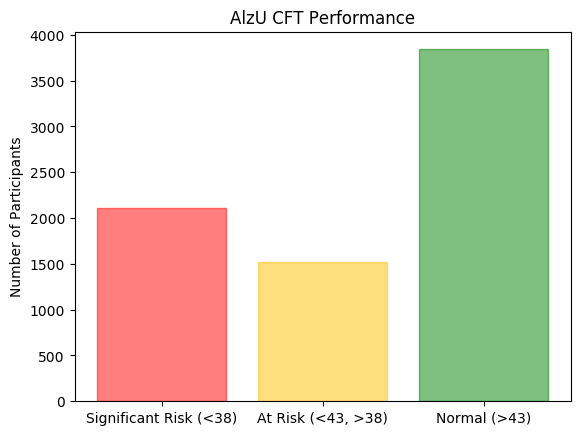

[2114, 1516, 3842]


In [43]:
red_zone = cog_takers[cog_takers['FinalScore'] <= 38]
orange_zone = cog_takers[((cog_takers['FinalScore'] > 38) & (cog_takers['FinalScore'] <= 43))]
green_zone = cog_takers[cog_takers['FinalScore'] > 43]

objects = ('Significant Risk (<38)', 'At Risk (<43, >38)', 'Normal (>43)')
y_pos = np.arange(len(objects))
performance = [red_zone.shape[0],orange_zone.shape[0], green_zone.shape[0]]
 
barlist=plt.bar(y_pos, performance, align='center', alpha=0.5)

barlist[0].set_color('#FF0000')
barlist[1].set_color('#FFBF00')
barlist[2].set_color('g')

plt.xticks(y_pos, objects)
plt.ylabel('Number of Participants')
plt.title('AlzU CFT Performance')
 
plt.show()

print(performance)

### 1.2: Pre-Process 

In [44]:
X = all_data.copy()

#### For those that have not taken CFT, replace value with mean

In [45]:
avg_cft_score = cog_takers['FinalScore'].mean()

X['FinalScore'].fillna(avg_cft_score, inplace=True)

#### Pre-process the features

Convert the alzU columns to ints, and Replace "NaN" and empty strings with the mean of column

In [46]:
idx_of_first_alzu_q = 62
idx_of_last_non_prompt_alz_u_q = 175
open_ended_alzu_indices = [64, 99, 120, 122, 124, 134, 171,175] #columns where they could enter in anything 

for col_idx in range(idx_of_first_alzu_q, idx_of_last_non_prompt_alz_u_q + 1):
    col_name = cols[col_idx]
    print(col_name)
    if (col_idx in open_ended_alzu_indices):
        continue
    print(X[col_name].unique())
    
    # first convert all nan and empty to -1, so that the conversion of the column to astype int doesn't break
    X[col_name].fillna(-1, inplace=True)
    print(X[col_name].unique())
    X[col_name].replace([''], [-1], inplace=True)
    X[col_name].replace(['1.11111E+77'], [-1], inplace=True) # handle the bizarre entry that was breaking this
    X[col_name] = (X[col_name]).astype(int)
    
    X[col_name].replace([-1], [np.NaN], inplace=True)
    column_mean = X[col_name].mean()
    X[col_name].fillna(column_mean, inplace=True)
    
    
    
    print(str(col_idx) + ": " + col_name + ": " +str(X[col_name].dtype))
    print(X[col_name].unique())

How many lessons did you complete on AlzU.org?_Response
[nan '1' '2' '3' '4' '']
[-1 '1' '2' '3' '4' '']
62: How many lessons did you complete on AlzU.org?_Response: float64
[ 2.65112782  1.          2.          3.          4.        ]
Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response
[nan '0' '3' '' '7' '1' '2' '5' '4' '6']
[-1 '0' '3' '' '7' '1' '2' '5' '4' '6']
63: Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response: float64
[ 1.35351882  0.          3.          7.          1.          2.          5.
  4.          6.        ]
Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Other (please specify)
Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something 

Transform some true false columns

In [47]:
def transform_true_false_col(col_name):
    replaced_NaNs = X[col_name].fillna(-1)
    replaced_t_f = replaced_NaNs.replace([False,True],[0,1])    
    replaced_t_f = replaced_t_f.astype(int)
    replaced_t_f.replace([-1], [np.NaN], inplace=True)
    column_mean = replaced_t_f.mean()
    replaced_t_f.fillna(column_mean, inplace=True)
    return replaced_t_f


X['MemConcern'] = transform_true_false_col('MemConcern')
X['ForgetFriends'] = transform_true_false_col('ForgetFriends')
X['PutThings'] = transform_true_false_col('PutThings')
X['ForgetWords'] = transform_true_false_col('ForgetWords')
X['LoseWay'] = transform_true_false_col('LoseWay')
X['IsMemoryWorse'] = transform_true_false_col('IsMemoryWorse')

Transform some yes no and other string columns...Taking some liberties here with how to encode them

In [48]:
X['FamilyHistory'].fillna(-1, inplace=True)
X['FamilyHistory'].replace(['', 'no', 'yes'], [-1,0,1], inplace=True)
X['FamilyHistory'].replace([-1], [np.NaN], inplace=True)

X['FamilyHistoryAge'].fillna(-1, inplace=True)
X['FamilyHistoryAge'].replace(['', 'Select', 'none', 'mild', 'other', 'alzh'], [-1,-1,0,1,2,3], inplace=True)
X['FamilyHistoryAge'].replace([-1], [np.NaN], inplace=True)

X['Supplements'].fillna(-1, inplace=True)
X['Supplements'].replace(['Select', 'No', 'Yes'], [-1,0,1], inplace=True)
X['Supplements'].replace([-1], [np.NaN], inplace=True)


Drop columns that we know are not good for ML models

In [49]:
X = X.drop(['Joined', 'User ID', 'First Name', 'Email', 'Lesson Group', 'UserID', 'FirstName', 'Respondent ID_', 'Collector ID_', 'IP Address_', 'Email Address_', 'First Name', 'Last Name_', 'Gender_y', 'DoB', 'joined_Open-Ended Response', 'email_Open-Ended Response', 'Start Date_', 'End Date_', 'First Name_', 'Custom Data 1_'], axis=1)

Drop columns from the CFT Dataset, THAT MAY BE OF USE LATER, but are just of inconvenient data types...Also we need to confirm that they do not influence the FinalScore

In [50]:
X = X.drop(['RegDate','DateTaken','Homoscyteine', 'Source', 'Working', 'CompUser', 'DeviceUsed'], axis=1)

In [51]:
X = X.drop(['recallscore', 'placescore', 'MouseScore', 'Country', 'Postcode', 'Ethnicy', 'Interrupted', 'Functioned', 'FastInternet', 'ScreenClear', 'MaritalStatus', 'Dependents', 'Occupation', 'PrimaryIncome', 'HouseholdIncome', 'PrimaryIncomeOccupation', 'FirstPriority', 'SecondPriority', 'OtherPriority', 'ass', 'combocs'], axis=1)

There are many questions, particularly in the CFT portion, where there are no responses.  We drop those columns below

In [52]:
for col in X.columns:
    if (X[col].dtype != 'int64' and X[col].dtype != 'float64'):
        if(len(X[col].unique()) == 1 and X[col].unique() == ['']):
            X.drop(col, axis=1, inplace=True)
        


Drop the alzU columns where the format is open-ended.  Some of them have interesting data, but hard to think about how to convert them into numeric at this time.  Come back to this.

In [53]:
for open_ended_idx in open_ended_alzu_indices:
    col_name = cols[open_ended_idx]
    X.drop(col_name, axis=1, inplace=True)

Drop the written responses field for this round

In [54]:
X.drop(memory_prompt, axis=1, inplace=True)
X.drop(tech_prompt, axis=1,inplace=True)

In [55]:
# make sure that all columns are ints or floats and convert NaN into mean for all columns
for col in X.columns:
    if (X[col].dtype !='int64' and X[col].dtype !='float64'):
        print("PROBLEM! COLUMN IS NOT IN NUMERICAL FORMAT")
        print(col + ": " + str(X[col].dtype))
    else:
        column_mean = X[col].mean()
        X[col].fillna(column_mean, inplace=True)

### 1.2 Classification

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

def run_and_print_models(x_train, y_train, x_test, y_test):
    features_importance_dict = {}
    
    #increments a features "importance" based on its weight in a model and the performance of that model
    def update_features_dict(feature_weights, performance):
#         print("FEATURE WEIGHTS")
#         print(feature_weights)       
        absolute_feature_weights = np.absolute(feature_weights)
#         print("ABS VALUE")
#         print(absolute_feature_weights)
        sorted_feature_weights_indices = np.argsort(absolute_feature_weights) # list of feature indices, sorted ascending by absolute value of feature weight 
#         print("Num FEATURES: " + str(len(feature_weights)))
        for ranking, feature_index in enumerate(sorted_feature_weights_indices):            
            feature_name = x_train.columns[feature_index]
#             print("Feature: ")
#             print(feature_name)
#             print("Ranking: ")
#             print(ranking)
            feature_ranking = ranking * performance
#             print("Travis Feature Ranking Rating:")
#             print(feature_ranking)
#             print(feature_ranking)
            if feature_name in features_importance_dict:
                features_importance_dict[feature_name] += feature_ranking
            else:
                features_importance_dict[feature_name] = feature_ranking
    
    def get_top_n_features(n, feature_weights):
        top_n_idx = np.argsort(feature_weights)[-n:] #SHOULD I BE USING ABSOLUTE VALUE?
        top_n_features = [x_train.columns[i] for i in top_n_idx]
        return top_n_features
    
    models = {
        "3-Nearest-Neighbors": KNeighborsClassifier(n_neighbors=3),
        "Linear Regression": LinearRegression(),
        "Decision Tree": tree.DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=2,
                                 random_state=0),
        "Support Vector Machines": svm.SVC(kernel='linear')    
    }
    
    for name, model in models.iteritems():
        model.fit(x_train, y_train)
        performance = model.score(x_test, y_test)
        print(name + " Classification Accuracy: " + str(performance))
        if (name == "3-Nearest-Neighbors"):
            continue
        elif (name == "Support Vector Machines"):
            feature_weights = model.coef_[0]
        elif(name=="Linear Regression"):
            feature_weights = model.coef_
        else:
            feature_weights = model.feature_importances_
#         print(name + " Top Features: ")
#         for idx, feat in enumerate(get_top_n_features(5, feature_weights)):
#             print(str(idx + 1) + ": " + feat)
        
        update_features_dict(feature_weights, performance)
    import operator

    sorted_x = sorted(features_importance_dict.items(), key=operator.itemgetter(1), reverse=True)
    for idx, feat_score_and_weight in enumerate(sorted_x):
        if (idx > 9):
            break
        print(str(idx + 1) + ": " + str(feat_score_and_weight))

### 1.2.1: Two-Classes

#### Classify cog scores on Median (above median = 1, below median = 0)

In [57]:
# X_two_class = X.copy()
# median_score = X_two_class['FinalScore'].median()

# X_two_class.loc[X_two_class['FinalScore'] < median_score, 'FinalScore'] = 0
# X_two_class.loc[X_two_class['FinalScore'] >= median_score, 'FinalScore'] = 1

# y_two_class = X_two_class['FinalScore']
# X_two_class = X_two_class.drop(['FinalScore'], axis=1)

# X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X_two_class,y_two_class)


# print(X_train_two.shape)
# print(X_test_two.shape)
# print(y_train_two.shape)
# print(y_test_two.shape)

# print("Label Division...........")
# print(y_two_class[y_two_class == 0].count())
# print(y_two_class[y_two_class == 1].count())


In [58]:
# run_and_print_models(X_train_two, y_train_two, X_test_two, y_test_two)

### 1.2.2: Three-Class Classification

#### Split based on the scoring categories provided here: http://www.foodforthebrain.org/alzheimers-prevention/take-the-test/interpreting-results.aspx

In [59]:
# X_three_class = X.copy()

# X_three_class.loc[X_three_class['FinalScore'] <= 38, 'FinalScore'] = 0
# X_three_class.loc[((X_three_class['FinalScore'] > 38) & (X_three_class['FinalScore'] <= 43)), 'FinalScore'] = 1
# X_three_class.loc[X_three_class['FinalScore'] > 43, 'FinalScore'] = 2

# y_three_class = X_three_class['FinalScore']
# X_three_class = X_three_class.drop(['FinalScore'], axis=1)

# X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(X_three_class,y_three_class)

In [60]:
# run_and_print_models(X_train_three, y_train_three, X_test_three, y_test_three)

## Experiment 2: Analysis of best models for Writing Samples

In [61]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# import nltk
# import re
# from collections import Counter
# import string
# import pprint

# have_writing = all_data[((all_data[memory_prompt] != "") | (all_data[tech_prompt] != ""))].copy()

# print(have_writing.shape)

# writing_samples = have_writing.iloc[:,memory_prompt_idx:tech_prompt_idx + 1]

# print(writing_samples.shape)

# cft_scores = have_writing['FinalScore']

# print(cft_scores.shape)

# #replace NaN with mean
# cft_median_score = cft_scores.median()
# cft_mean_score = cft_scores.mean()

# cft_scores.fillna(cft_mean_score, inplace=True)
# print(cft_median_score)
# print(cft_scores.head())




# print(cft_scores.head())


In [62]:
# have_writing

### Experiment 2.1: Two-class Classification using TF-IDF features 

In [63]:
# # https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.where.html#pandas.Series.where
# two_class_cft = cft_scores.copy()
# two_class_cft = two_class_cft.where(two_class_cft >= cft_median_score, 0) 
# two_class_cft = two_class_cft.where(two_class_cft < cft_median_score, 1)

In [64]:
# ## Models to test
# model_dict = {
#     'Naive Bayes': MultinomialNB(),
#     'Support Vector Machines': SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None),
#     'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=2,
#                                  random_state=0),
#     'Decision Tree': tree.DecisionTreeClassifier(),
#     "3-Nearest-Neighbors": KNeighborsClassifier(n_neighbors=3)
# }

#### Fit Memory Responses Alone

In [65]:
# mem_prompt = have_writing.iloc[:,memory_prompt_idx]

# print(mem_prompt.shape)
# mem_prompt.head()

In [66]:
# mem_train_two, mem_test_two, score_train_two, score_test_two = train_test_split(mem_prompt,two_class_cft)

In [67]:
# best_mem_clf = {
#     'Name': None,
#     'FitModel':None,
#     'Score': 0
# }
# for model_name in model_dict:
#     model = model_dict[model_name]
#     clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', model)])
#     clf.fit(mem_train_two, score_train_two)

#     predicted = clf.predict(mem_test_two)
#     predict_accuracy = np.mean(predicted == score_test_two)
#     if (predict_accuracy >= best_mem_clf['Score']):
#         best_mem_clf['Name'] = model_name
#         best_mem_clf['FitModel'] = clf
#         best_mem_clf['Score'] = predict_accuracy
#     print(model_name + " Prediction Accuracy:")
#     print(predict_accuracy)

In [68]:
# best_mem_clf

In [69]:
# for step in best_mem_clf['FitModel'].steps: 
#     if step[0] == 'clf':
#         feature_importances = step[1].feature_importances_ #get_params()

# feature_importances.shape

#### Fit Tech Responses Alone

In [70]:
# tech_prompt_responses = have_writing.iloc[:,tech_prompt_idx]
# print(tech_prompt_responses.shape)
# print(tech_prompt_responses.head())

# tech_train_two, tech_test_two, score_train_two, score_test_two = train_test_split(tech_prompt_responses,two_class_cft)

In [71]:
# for model_name in model_dict:
#     model = model_dict[model_name]
#     clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', model)])
#     clf.fit(tech_train_two, score_train_two)

#     predicted = clf.predict(tech_test_two)
#     predict_accuracy = np.mean(predicted == score_test_two) 
#     print(model_name + " Prediction Accuracy:")
#     print(predict_accuracy)

### Experiment 2.2: Three-class Classification using TF-IDF features 

In [72]:
# three_class_cft = cft_scores.copy()

# three_class_cft = three_class_cft.where(three_class_cft <= 38, 0)
# three_class_cft = three_class_cft.where((three_class_cft > 38 & three_class_cft <=43), 1)
# three_class_cft = three_class_cft.where(three_class_cft > 43, 2)

In [73]:
# def split_words(sample_string):
#     return re.sub('['+string.punctuation.replace('\'','')+']',' ',sample_string).split()

# # Number of Words in Responses
# print(len(split_words(sample_mem)))
# print(len(split_words(sample_tech)))

In [74]:
# # Number of Unique Words in Response
# print(len(np.unique(split_words(sample_mem))))
# print(len(np.unique(split_words(sample_tech))))

In [75]:
# #Honore's lexical richness calculation

# def calc_honores(sample_string):
#     split_string = re.sub('['+string.punctuation.replace('\'','')+']',' ',sample_string).split()
#     N = len(split_string) #number of words
#     uniq_words, counts = np.unique(split_string, return_counts = True)
#     v = len(uniq_words) # number of unique words
#     v1 = len(np.where(counts==1)[0])
    
#     honores = (100*math.log(N))/(1-v1/v)
#     return honores

# print(calc_honores(sample_mem))
# print(calc_honores(sample_tech))

# print(calc_honores("I went to store then I went to the gym then I went to the house"))

In [76]:
# #Brunet's W index
# def calc_brunets(sample_string):
#     split_string = re.sub('['+string.punctuation.replace('\'','')+']',' ',sample_string).split()
#     N = len(split_string) #number of words
#     uniq_words, counts = np.unique(split_string, return_counts = True)
#     v = len(uniq_words) # number of unique words
#     brunets = N**(v-0.165)
#     return brunets

# print(calc_brunets(sample_mem))
# print(calc_brunets(sample_tech))

## Experiment 3: Use Renee's Correlated Features to Build a Model

Summary Stats

In [77]:
#https://raw.githubusercontent.com/dwyl/english-words/master/words.txt
with open('words.txt','r') as words:
    word_list = words.read().splitlines()

word_list = [w.lower() for w in word_list]


len(word_list)

466544

In [78]:
import nltk
nltk.download('tagsets')
nltk.help.upenn_tagset()




def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)    
    except ZeroDivisionError as z:
        return None
    except Exception as e:
        return handle(e)


# ## Tokenization

# In[69]:


#Mis-spellings, word length
#rm puctuation
#keep contractions, posessives
def list_tokenize(response):
    return re.sub('['+string.punctuation.replace('\'','')+']',' ',response).split()


# ## Information extraction nltk

# In[70]:


#information-extraction
#https://www.nltk.org/book/ch07.html
def ie_preprocess(document):
    #sentence segmentation
    sentences = nltk.sent_tokenize(document) 
    #tokenization
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    #pos tagging
    sentences = [nltk.pos_tag(sent) for sent in sentences] 
    
    return sentences


# ## Uniq, V

# In[71]:


def uniq_words (response,token_list=None, counts_vector_return=False,uniq_set_return=False):
    if token_list is None: token_list = list_tokenize(response)
    if counts_vector_return and uniq_set_return: return np.unique(token_list,return_counts=True)
    
    if counts_vector_return and not uniq_set_return: return np.unique(token_list,return_counts=True)[1]
    
    if uniq_set_return and not counts_vector_return: return np.unique(token_list)
    #typical case, investigating number of uniq responses
    
    return len(np.unique(token_list))
        


# ## V1 

# In[72]:


def single_appearances (response,counts=None):
    if counts is None: counts = uniq_words(response,counts_vector_return=True)
    return len(np.where(counts==1)[0])


# ## N-grams

# In[73]:


#http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
#input
def find_bigrams(response, return_list=False):
    input_list = list_tokenize(response)
    bigrams = zip(input_list, input_list[1:])
    if return_list: return [b for b in bigrams]
    else: return bigrams


# ## Word count

# In[74]:


def word_count(response):
    return len(list_tokenize(response))


# ## Sentence count

# In[75]:


def sentence_count(response):
    return len(ie_preprocess(response))


# ### POS tagging

# In[76]:


#information-extraction
#https://www.nltk.org/book/ch07.html
def ie_preprocess(document):
    #sentence segmentation
    sentences = nltk.sent_tokenize(document) 
    #tokenization
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    #pos tagging
    sentences = [nltk.pos_tag(sent) for sent in sentences] 
    
    return sentences


# ## Rates

# In[77]:


def pos_rate(response,pos_response=None,tag_set=None,denom_set=None,N=None,nn=False,pn=False,vb=False,proper=None):
    
    if pos_response is None: pos_response = ie_preprocess(response)
        
    
    if tag_set is None:
        #common nouns, excluding proper nouns
        if nn: tag_set = ['NN','NNS']
        elif vb: tag_set = ['VB','VBD','VBG','VBN','VBP','VBZ'] 
        elif pn: tag_set = ['PRP','PRP$']
        elif proper: 
            tag_set = ['PRP','PRP$','WP','WP$']
            denom_set = ['PRP','PRP$','WP','WP$','NN','NNP','NNPS','NNS']
            
        
    pos_count = sum([1 for sentence in pos_response for word in sentence if word[1] in tag_set])
    
    if denom_set: 
        denom_count = sum([1 for sentence in pos_response for word in sentence if word[1] in denom_set])
    else:
        if N is None: N = word_count(response)
        denom_count = N
    
    if (denom_count == 0):
        return 0
    else:
        return pos_count/denom_count
        

#         sum([1 for sentence in pos_test for word in sentence if word[1] in ['VB','VBD','VBG','VBN','VBP','VBZ'] ])


# ## Honore's R 
# ![image.png](attachment:image.png)
# https://books.google.com/books?id=CwC4CwAAQBAJ&pg=PA111&lpg=PA111&dq=honore+statistic+lexical+richness&source=bl&ots=LPnM2j9oX5&sig=HGObkoMYRy6lLsgc80Y7tUMT7vk&hl=en&sa=X&ved=2ahUKEwjv0ubE7vTdAhXwYd8KHVRfCiMQ6AEwCXoECAUQAQ#v=onepage&q=honore&f=false
# 
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.2.1359&rep=rep1&type=pdf
# 
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.484.4648&rep=rep1&type=pdf
# 
# viii) Honoré’s R statistic.
# If V1 denotes the number of hapax legomena recorded, then Honoré (1979) defined his
# statistic as:
# 
# *R = 100log(N)/(1 - V1/V)*
# 
# As a measure of vocabulary richness which has the virtue of being insensitive to text
# length, it has been used in stylometric studies by Holmes (1992) and Holmes and
# Stylometric analysis of conversational speech
# Forsyth (1995). Values of R typically range from 1000 to 2000 with higher values
# implying richer vocabularies in the sense that a greater number of words appear
# infrequently.
# 
# 
# https://pdfs.semanticscholar.org/11f9/ef33ad001f7638ba29ee8109077de92eb1bb.pdf
# 
# 
# Assuming log == base e...fits with 1000-2000 assumption
# 
# 
# 

# In[78]:


def honore_r(response,v=None,v1=None, N=None):
    if N is None: N = word_count(response)
    if v is None: v = uniq_responses(response)
    if v1 is None: 
        counts = uniq_responses(response,counts_vector_return=True)
        v1 = len(np.where(counts==1)[0])
    return (100*math.log(N))/(1-v1/v)


# ## Brunet's W
# W = N**(V −0.165)
# 
# (vii) Brunet’s W index.
# This index, devised by Brunet (1978) and used successfully by Holmes and Forsyth
# (1995), is a measure of vocabulary richness which is insensitive to text length. It is
# defined as:
# 
# W= N^(V-0.165)
# where N is the text length, V the number of different words and (-0.165) is a scaling
# constant proposed by Brunet. The measure generally varies between 10 and 20 with a
# low value indicating a lexically richer speech.
# https://pdfs.semanticscholar.org/11f9/ef33ad001f7638ba29ee8109077de92eb1bb.pdf

# In[79]:


def brunet_w(response,N=None, v=None):
    if N is None: N = word_count(response)
    if v is None: v = uniq_responses(response)
    return N**(v-0.165)


# ## Moving window

# In[80]:


#10-window size generator
#https://docs.python.org/release/2.3.5/lib/itertools-example.html
def window(seq, n=10):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def coord_conjunctions_init(response):
    return sum([1 for sentence in ie_preprocess(response) if sentence[0][1] == 'CC'])

def misspelt(response):
    return sum([1 for word in list_tokenize(response) if word.lower() not in word_list])

def calc_MATTR(mr):
    window_iterable = window(list_tokenize(mr),n=min(len(list_tokenize(mr)),10))
    return np.mean([len(np.unique(mw))/min(len(list_tokenize(mr)),10) for mw in window_iterable])

[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/travisallen/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria 

### Exp 3.1: See how language features compare to non-lang for users with memory responses

In [79]:
have_mem_indices = all_data.index[all_data[memory_prompt] != ""] #Gets the indices of rows that have memory response
print(have_mem_indices.shape)


(364,)


In [133]:
have_mem_indices

Index([u'28844', u'28858', u'28867', u'28881', u'29004', u'29051', u'29056', u'29059', u'29073', u'29079',
       ...
       u'59079', u'59103', u'59200', u'59243', u'59321', u'59682', u'59826', u'60026', u'60056', u'60130'], dtype='object', length=364)

In [124]:
mem_cft_scores = pd.Series(all_data.loc[have_mem_indices]['FinalScore'], index=have_mem_indices) #Will be used as target for both language and non-language experiments
print(mem_cft_scores.shape)

#replace NaN with mean
mem_cft_median_score = mem_cft_scores.median()
mem_cft_mean_score = mem_cft_scores.mean()
mem_cft_scores.fillna(mem_cft_mean_score, inplace=True)


### MAKE A THREE-CLASS TARGET, BASED ON CFT WEBSITE
mem_THREE_class_cft = mem_cft_scores.copy()

mem_THREE_class_cft = mem_THREE_class_cft.where(mem_THREE_class_cft > 38, 0)
mem_THREE_class_cft = mem_THREE_class_cft.where(mem_THREE_class_cft < 43, 2)
mem_THREE_class_cft = mem_THREE_class_cft.where(((mem_THREE_class_cft == 0) | (mem_THREE_class_cft == 2)), 1)

(364,)


### Hold Out Test Set

np.random.choice(have_mem_indices,(1,int(.20*len(have_mem_indices))),replace=False)

array([['40712', '44816', '43211', '51913', '41880', '39575', '29112',
        '54397', '29004', '52080', '44345', '57361', '29113', '49691',
        '40020', '38603', '46323', '29136', '55057', '54236', '43644',
        '47950', '29670', '55991', '41751', '30279', '35853', '58820',
        '29615', '35337', '59682', '42780', '40118', '54884', '29056',
        '32304', '51163', '43205', '32565', '29234', '53994', '58441',
        '29084', '32601', '34097', '46015', '42587', '36881', '47461',
        '49925', '39966', '54091', '43429', '29608', '43700', '45405',
        '29563', '54740', '30384', '29768', '32182', '31723', '32871',
        '50433', '40693', '39695', '46613', '41045', '40854', '38440',
        '38649', '45884']], dtype=object)

In [137]:
held_out_test_mem_idx = ['40712', '44816', '43211', '51913', '41880', '39575', '29112', '54397', '29004', '52080', '44345', '57361', '29113', '49691', '40020', '38603', '46323', '29136', '55057', '54236', '43644', '47950', '29670', '55991', '41751', '30279', '35853', '58820', '29615', '35337', '59682', '42780', '40118', '54884', '29056', '32304', '51163', '43205', '32565', '29234', '53994', '58441', '29084', '32601', '34097', '46015', '42587', '36881', '47461', '49925', '39966', '54091', '43429', '29608', '43700', '45405', '29563', '54740', '30384', '29768', '32182', '31723', '32871', '50433', '40693', '39695', '46613', '41045', '40854', '38440', '38649', '45884']

In [139]:
y_mem_heldout = mem_THREE_class_cft[held_out_test_mem_idx]

In [141]:
y_mem_heldout.shape

(72,)

### Dev Set 

In [146]:
train_dev_mem_ix = [m for m in have_mem_indices if m not in held_out_test_mem_idx]

np.random.choice(train_dev_mem_ix,(1,int(.20*len(train_dev_mem_ix))),replace=False)

In [157]:
dev_mem_idx = ['46047', '58728', '42364', '39539', '39862', '30087', '58354',
        '47480', '56239', '46765', '39880', '34753', '31795', '45647',
        '43233', '32846', '55823', '31075', '43830', '39573', '53678',
        '57834', '32144', '39171', '52174', '39582', '33976', '45821',
        '43155', '53050', '52053', '53125', '39082', '59103', '37078',
        '33444', '29051', '40017', '39830', '42876', '29970', '31871',
        '31482', '39319', '54924', '44439', '38414', '29502', '30865',
        '32233', '43247', '57709', '53472', '40938', '29129', '57407',
        '42040', '40253']

In [158]:
y_mem_dev = mem_THREE_class_cft[dev_mem_idx]

In [159]:
y_mem_dev.shape

(58,)

### Train Set 

In [160]:
train_mem_idx =  [i for i in train_dev_mem_ix if i not in dev_mem_idx]

In [163]:
y_mem_train = mem_THREE_class_cft[train_mem_idx]

364

In [196]:
def prediction_accuracies(X_train, X_test, y_train, y_test):
    ## Models to test
    model_dict = {
        'Naive Bayes': MultinomialNB(),
        'Support Vector Machines': SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=2,
                                     random_state=0),
        'Decision Tree': tree.DecisionTreeClassifier(),
        "3-Nearest-Neighbors": KNeighborsClassifier(n_neighbors=3)
    }

    for model_name in model_dict:
        model = model_dict[model_name]
        model.fit(X_train, y_train)

        predicted = model.predict(X_test)
        predict_accuracy = np.mean(predicted == y_test)
        
        if (model_name == 'Naive Bayes'):
            nb_predic_acc = predict_accuracy
        if (model_name == 'Support Vector Machines'):
            svm_predic_acc = predict_accuracy
        if(model_name == 'Random Forest'):
            rf_predic_acc = predict_accuracy
        if(model_name == 'Decision Tree'):
            dec_acc = predict_accuracy
        if(model_name == "3-Nearest-Neighbors"):
            knn_acc = predict_accuracy
        print(model_name + " Prediction Accuracy:")
        print(predict_accuracy)
        
    return nb_predic_acc, svm_predic_acc, rf_predic_acc, dec_acc, knn_acc

In [164]:
# def prediction_accuracy(model_name, X_train, X_test, y_train, y_test):
#     model_dict = {
#         'Naive Bayes': MultinomialNB(),
#         'Support Vector Machines': SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None),
#         'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=2,
#                                      random_state=0),
#         'Decision Tree': tree.DecisionTreeClassifier(),
#         "3-Nearest-Neighbors": KNeighborsClassifier(n_neighbors=3)
#     }

#     model = model_dict[model_name]
#     model.fit(X_train, y_train)

#     predicted = model.predict(X_test)
#     predict_accuracy = np.mean(predicted == y_test)

#     return predict_accuracy

#### Exp 3.1, Part 1: Run models on Non-Language Data 

In [85]:
mem_responses_no_text = X.loc[have_mem_indices]
mem_responses_no_text.drop('FinalScore', axis=1, inplace=True) #Those with memory respones: all data besides text

In [197]:
no_text_mem_train = mem_responses_no_text.loc[train_mem_idx]

no_text_mem_dev = mem_responses_no_text.loc[dev_mem_idx]

nb_no_text_mem_acc, svm_no_text_mem_acc, rf_no_text_mem_acc, dec_tree_no_text_mem_acc, knn_no_text_mem_acc = prediction_accuracies( no_text_mem_train, no_text_mem_dev, y_mem_train, y_mem_dev)


3-Nearest-Neighbors Prediction Accuracy:
0.637931034483
Support Vector Machines Prediction Accuracy:
0.706896551724
Naive Bayes Prediction Accuracy:
0.568965517241
Random Forest Prediction Accuracy:
0.724137931034
Decision Tree Prediction Accuracy:
0.724137931034


#### Exp 3.2, Part 2: Run Models on Language Data

In [89]:
mem_responses = all_data.loc[have_mem_indices].iloc[:,memory_prompt_idx] #Just responses themselves
print(mem_responses.shape)

memory_response_df = mem_responses.to_frame(name='Response')
memory_response_df['NumWords'] = memory_response_df.apply(lambda row: word_count(row['Response']), axis=1)
memory_response_df['NumSentences'] = memory_response_df.apply(lambda row: sentence_count(row['Response'].decode('utf-8')), axis=1)
memory_response_df['V'] = memory_response_df.apply(lambda row: uniq_words(row['Response']), axis=1)
memory_response_df['V1'] = memory_response_df.apply(lambda row: single_appearances(row['Response']), axis=1)
memory_response_df['MATTR'] = memory_response_df.apply(lambda row: calc_MATTR(row['Response']), axis=1)
memory_response_df['CoordinatingConjunctions'] = memory_response_df.apply(lambda row: coord_conjunctions_init(row['Response'].decode('utf-8')), axis=1)
memory_response_df['Misspellings'] = memory_response_df.apply(lambda row: misspelt(row['Response'].decode('utf-8')), axis=1)
memory_response_df['NounRate'] = memory_response_df.apply(lambda row: pos_rate(row['Response'].decode('utf-8'),nn=True), axis=1)

memory_response_df['VerbRate'] = memory_response_df.apply(lambda row: pos_rate(row['Response'].decode('utf-8'),vb=True), axis=1)

memory_response_df['PronounRate'] = memory_response_df.apply(lambda row: pos_rate(row['Response'].decode('utf-8'),pn=True), axis=1) 

memory_response_df['ProperNounRate'] = memory_response_df.apply(lambda row: pos_rate(row['Response'].decode('utf-8'),proper=True), axis=1) 

memory_response_df.drop('Response', axis=1, inplace=True) #get rid of actual text

(364,)


In [90]:
memory_response_df.head()

NumWords  NumSentences   V  V1     MATTR  CoordinatingConjunctions  Misspellings  NounRate  VerbRate  PronounRate  ProperNounRate
28844        44             2  34  27  0.968571                         0             1  0.181818  0.204545     0.159091        0.466667
28858        65             4  49  39  0.967857                         0             0  0.230769  0.184615     0.123077        0.307692
28867        93             6  60  44  0.972619                         0             0  0.225806  0.182796     0.139785        0.382353
28881        54             2  45  38  0.982222                         0             2  0.111111  0.259259     0.148148        0.571429
29004        40             2  30  23  0.945161                         0             0  0.150000  0.175000     0.175000        0.500000

In [198]:
text_mem_train = memory_response_df.loc[train_mem_idx]

text_mem_dev = memory_response_df.loc[dev_mem_idx]

nb_text_mem_acc, svm_text_mem_acc, rf_text_mem_acc, dec_tree_text_mem_acc, knn_text_mem_acc = prediction_accuracies( text_mem_train, text_mem_dev, y_mem_train, y_mem_dev)

3-Nearest-Neighbors Prediction Accuracy:
0.51724137931
Support Vector Machines Prediction Accuracy:
0.172413793103
Naive Bayes Prediction Accuracy:
0.706896551724
Random Forest Prediction Accuracy:
0.706896551724
Decision Tree Prediction Accuracy:
0.551724137931


#### Exp 3.2, Part 3:  Combine Text and No-Text and Test Same Models

In [199]:
combined_mem = mem_responses_no_text.join(memory_response_df)

In [200]:
combined_mem_train = combined_mem.loc[train_mem_idx]
combined_mem_dev = combined_mem.loc[dev_mem_idx]

In [95]:
#combined_mem_train, combined_mem_test, combined_score_train, combined_score_test = train_test_split(combined_mem,mem_THREE_class_cft)

In [201]:
nb_all_mem_acc, svm_all_mem_acc, rf_all_mem_acc, dec_all_text_mem_acc, knn_all_mem_acc = prediction_accuracies( combined_mem_train, combined_mem_dev, y_mem_train, y_mem_dev)

3-Nearest-Neighbors Prediction Accuracy:
0.620689655172
Support Vector Machines Prediction Accuracy:
0.241379310345
Naive Bayes Prediction Accuracy:
0.534482758621
Random Forest Prediction Accuracy:
0.741379310345
Decision Tree Prediction Accuracy:
0.706896551724


#### Exp 3.2, Part 4:  Add Text Features one at a time

For this experiment, we look only at the effect on Random Forest, which showed an improved prediction accuracy for JUST Lang data and Lang + Non-Lang data   

In [203]:
for idx, mem_resp_col in enumerate(memory_response_df.columns):
    feature_column = memory_response_df[mem_resp_col]
    concatenated = mem_responses_no_text.join(feature_column)

    X_train = concatenated.loc[train_mem_idx]
    X_dev = concatenated.loc[dev_mem_idx]
   
    model = RandomForestClassifier(n_estimators=100, max_depth=5,
                                     random_state=0)
    model.fit(X_train, y_mem_train)

    predicted = model.predict(X_dev)
    predict_accuracy = np.mean(predicted == y_mem_dev)
    
    if (predict_accuracy > rf_no_text_mem_acc):
        print("Feature Tested: " + mem_resp_col)
        print(predict_accuracy)
        print("................................")
    

Feature Tested: NumWords
0.793103448276
................................
Feature Tested: NumSentences
0.810344827586
................................
Feature Tested: V
0.810344827586
................................
Feature Tested: V1
0.775862068966
................................
Feature Tested: MATTR
0.810344827586
................................
Feature Tested: CoordinatingConjunctions
0.758620689655
................................
Feature Tested: Misspellings
0.810344827586
................................
Feature Tested: NounRate
0.775862068966
................................
Feature Tested: VerbRate
0.810344827586
................................
Feature Tested: PronounRate
0.793103448276
................................
Feature Tested: ProperNounRate
0.775862068966
................................


Now we take the best individually-performing feature additions and combine them with non-text:

In [210]:
good_mem_text_features = ['NumSentences', 'V', 'MATTR', 'Misspellings', 'VerbRate']

combined_good = mem_responses_no_text.join(memory_response_df[good_mem_text_features])

X_train = concatenated.loc[train_mem_idx]
X_dev = concatenated.loc[dev_mem_idx]

model = RandomForestClassifier(n_estimators=100, max_depth=5,
                                 random_state=0)
model.fit(X_train, y_mem_train)

predicted = model.predict(X_dev)
predict_accuracy = np.mean(predicted == y_mem_dev)

print(predict_accuracy)

0.775862068966


In [98]:
# good_text_features_mem = pd.DataFrame()

# for idx, mem_resp_col in enumerate(memory_response_df.columns):
#     print("Feature Tested: " + mem_resp_col)
#     if (mem_resp_col == "")
#     feature_column = memory_response_df[mem_resp_col]
    
    
#     concatenated = mem_responses_no_text.join(feature_column)

#     X_train, X_test, y_train, y_test = train_test_split(concatenated,mem_THREE_class_cft)
    
#     model = RandomForestClassifier(n_estimators=100, max_depth=2,
#                                      random_state=0)
#     model.fit(X_train, y_train)

#     predicted = model.predict(X_test)
#     predict_accuracy = np.mean(predicted == y_test)

#     print(predict_accuracy)

#     print("................................")

### Exp 3.2: Do the same with Tech Responses

In [99]:
have_tech_indices = all_data.index[all_data[tech_prompt] != ""] #Gets the indices of rows that have tech response
print(have_tech_indices.shape)

tech_cft_scores = all_data.loc[have_tech_indices]['FinalScore'] #Will be used as target for both language and non-language experiments
print(tech_cft_scores.shape)

#replace NaN with mean
tech_cft_median_score = tech_cft_scores.median()
tech_cft_mean_score = tech_cft_scores.mean()
tech_cft_scores.fillna(tech_cft_mean_score, inplace=True)


## MAKE TARGET TWO-CLASSES, SPLIT ON MEDIUM
tech_two_class_cft = tech_cft_scores.copy()
tech_two_class_cft = tech_two_class_cft.where(tech_two_class_cft >= tech_cft_median_score, 0) 
tech_two_class_cft = tech_two_class_cft.where(tech_two_class_cft < tech_cft_median_score, 1)
### MAKE A THREE-CLASS TARGET, BASED ON CFT WEBSITE
tech_THREE_class_cft = tech_cft_scores.copy()

tech_THREE_class_cft = tech_THREE_class_cft.where(tech_THREE_class_cft > 38, 0)
tech_THREE_class_cft = tech_THREE_class_cft.where(tech_THREE_class_cft < 43, 2)
tech_THREE_class_cft = tech_THREE_class_cft.where(((tech_THREE_class_cft == 0) | (tech_THREE_class_cft == 2)), 1)

(424,)
(424,)


In [100]:
tech_responses_no_text = X.loc[have_tech_indices]
tech_responses_no_text.drop('FinalScore', axis=1, inplace=True) #Those with tech respones: all data besides text

no_text_tech_train, no_text_tech_test, tech_score_train, tech_score_test = train_test_split(tech_responses_no_text,tech_THREE_class_cft)

print_accuracies(no_text_tech_train, no_text_tech_test, tech_score_train, tech_score_test)

3-Nearest-Neighbors Prediction Accuracy:
0.688679245283
Support Vector Machines Prediction Accuracy:
0.198113207547
Naive Bayes Prediction Accuracy:
0.61320754717
Random Forest Prediction Accuracy:
0.735849056604
Decision Tree Prediction Accuracy:
0.754716981132


In [101]:
tech_responses = all_data.loc[have_tech_indices].iloc[:,tech_prompt_idx] #Just responses themselves
print(tech_responses.shape)

tech_response_df = tech_responses.to_frame(name='Response')
tech_response_df['NumWords'] = tech_response_df.apply(lambda row: word_count(row['Response']), axis=1)
tech_response_df['NumSentences'] = tech_response_df.apply(lambda row: sentence_count(row['Response'].decode('utf-8')), axis=1)
tech_response_df['V'] = tech_response_df.apply(lambda row: uniq_words(row['Response']), axis=1)
tech_response_df['V1'] = tech_response_df.apply(lambda row: single_appearances(row['Response']), axis=1)
tech_response_df['MATTR'] = tech_response_df.apply(lambda row: calc_MATTR(row['Response']), axis=1)
tech_response_df['CoordinatingConjunctions'] = tech_response_df.apply(lambda row: coord_conjunctions_init(row['Response'].decode('utf-8')), axis=1)
tech_response_df['Misspellings'] = tech_response_df.apply(lambda row: misspelt(row['Response'].decode('utf-8')), axis=1)
tech_response_df['NounRate'] = tech_response_df.apply(lambda row: pos_rate(row['Response'].decode('utf-8'),nn=True), axis=1)

tech_response_df['VerbRate'] = tech_response_df.apply(lambda row: pos_rate(row['Response'].decode('utf-8'),vb=True), axis=1)

tech_response_df['PronounRate'] = tech_response_df.apply(lambda row: pos_rate(row['Response'].decode('utf-8'),pn=True), axis=1) 

tech_response_df['ProperNounRate'] = tech_response_df.apply(lambda row: pos_rate(row['Response'].decode('utf-8'),proper=True), axis=1) 

tech_response_df.drop('Response', axis=1, inplace=True) #get rid of actual text

(424,)


In [102]:
for idx, tech_response in enumerate(tech_responses):
    if(idx == 52):
        print(tech_response)
        pos_rate(tech_response.decode('utf-8'),proper=True)
        break
    

Not much


In [103]:
text_tech_train, text_tech_test, tech_score_train, tech_score_test = train_test_split(tech_response_df,tech_THREE_class_cft)

print_accuracies(text_tech_train, text_tech_test, tech_score_train, tech_score_test)

3-Nearest-Neighbors Prediction Accuracy:
0.566037735849
Support Vector Machines Prediction Accuracy:
0.198113207547
Naive Bayes Prediction Accuracy:
0.679245283019
Random Forest Prediction Accuracy:
0.688679245283
Decision Tree Prediction Accuracy:
0.575471698113


In [104]:
combined_tech = tech_responses_no_text.join(tech_response_df)
combined_tech_train, combined_tech_test, combined_score_train, combined_score_test = train_test_split(combined_tech,tech_THREE_class_cft)

print_accuracies(combined_tech_train, combined_tech_test, combined_score_train, combined_score_test)

3-Nearest-Neighbors Prediction Accuracy:
0.61320754717
Support Vector Machines Prediction Accuracy:
0.141509433962
Naive Bayes Prediction Accuracy:
0.547169811321
Random Forest Prediction Accuracy:
0.650943396226
Decision Tree Prediction Accuracy:
0.735849056604


In [105]:
for idx, tech_resp_col in enumerate(tech_response_df.columns):
    print("Feature Tested: " + tech_resp_col)
    feature_column = tech_response_df[tech_resp_col]
    concatenated = tech_responses_no_text.join(feature_column)

    X_train, X_test, y_train, y_test = train_test_split(concatenated,tech_THREE_class_cft)
    
    model = RandomForestClassifier(n_estimators=100, max_depth=2,
                                     random_state=0)
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    predict_accuracy = np.mean(predicted == y_test)

    print(predict_accuracy)

    print("................................")

Feature Tested: NumWords
0.716981132075
................................
Feature Tested: NumSentences
0.669811320755
................................
Feature Tested: V
0.660377358491
................................
Feature Tested: V1
0.679245283019
................................
Feature Tested: MATTR
0.688679245283
................................
Feature Tested: CoordinatingConjunctions
0.764150943396
................................
Feature Tested: Misspellings
0.669811320755
................................
Feature Tested: NounRate
0.735849056604
................................
Feature Tested: VerbRate
0.698113207547
................................
Feature Tested: PronounRate
0.745283018868
................................
Feature Tested: ProperNounRate
0.72641509434
................................


Just take the the text features that improve it the most and add them all together

In [106]:
good_text_features_tech = pd.DataFrame()

good_text_features_tech_names = ["MATTR", "V", "CoordinatingConjunctions", "NounRate"]

for idx, tech_resp_col in enumerate(tech_response_df.columns):
    if (tech_resp_col in good_text_features_tech_names):
        print("Feature Added: " + tech_resp_col)
        feature_column = tech_response_df[tech_resp_col]       
        good_text_features_tech[tech_resp_col] = feature_column


concatenated = tech_responses_no_text.join(good_text_features_tech)

X_train, X_test, y_train, y_test = train_test_split(concatenated,tech_THREE_class_cft)

model = RandomForestClassifier(n_estimators=100, max_depth=2,
                                 random_state=0)
model.fit(X_train, y_train)

predicted = model.predict(X_test)
predict_accuracy = np.mean(predicted == y_test)

print(predict_accuracy)

print("................................")

Feature Added: V
Feature Added: MATTR
Feature Added: CoordinatingConjunctions
Feature Added: NounRate
0.754716981132
................................
